In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from patsy import dmatrices, dmatrix


from PIL import Image
import requests
from io import BytesIO
import urllib3
urllib3.disable_warnings()

def show_image(url, size = (8,8)):
    response = requests.get(url,verify=False)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize = size)
    plt.axis('off')
    _ = plt.imshow(img, interpolation='lanczos')

ModuleNotFoundError: No module named 'requests'

# 1. Categorical predictors #

In [2]:
# data from ISL book: https://trevorhastie.github.io/ISLR/data.html
df = pd.read_csv("Auto.csv")
df.columns    

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name'],
      dtype='object')

In [3]:
# default data types
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

In [5]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


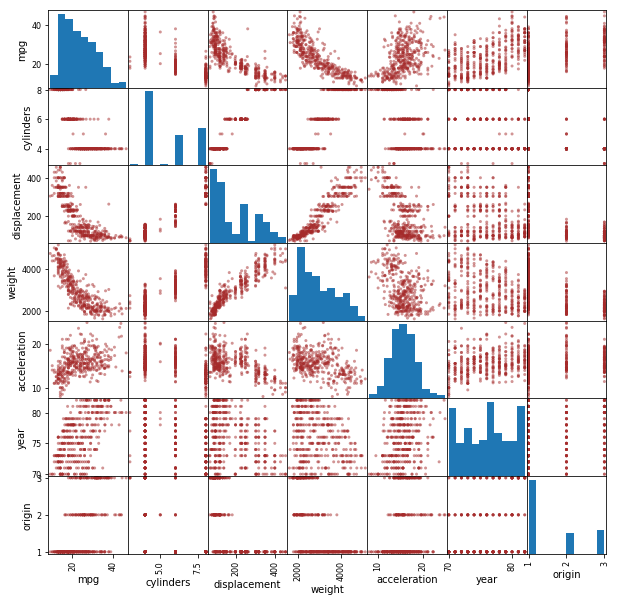

In [20]:
# some columns contain categorical data
# scatter_plot 
_ = pd.plotting.scatter_matrix(df, color="brown",figsize=(10,10),)

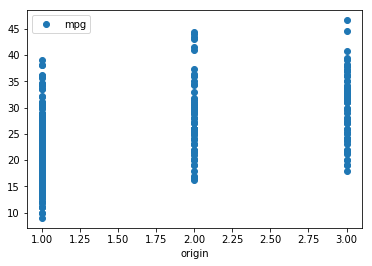

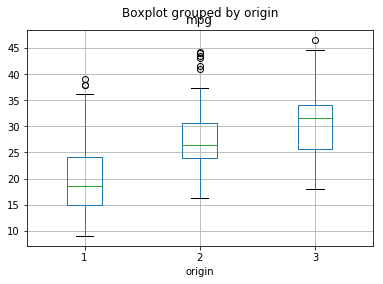

In [21]:
# use box-plot for categorical data 
# if results in categories are substantially difrent that feature might be important
_ = df.plot(x="origin", y="mpg", style='o')
_ = df.boxplot(column="mpg", by="origin") 

In [78]:
# dmatrices function splits and encodes data
# ''-1'' to have a model without the intercept
#models = [
#    'mpg ~ origin',
#    'mpg ~ C(origin)'
#    'mpg ~ C(origin) - 1',
#]
y, X = dmatrices('mpg ~ C(origin) ', data=df, return_type='dataframe') 
model = sm.OLS(y, X) 
result = model.fit() 
X.dtypes

Intercept         float64
C(origin)[T.2]    float64
C(origin)[T.3]    float64
dtype: object

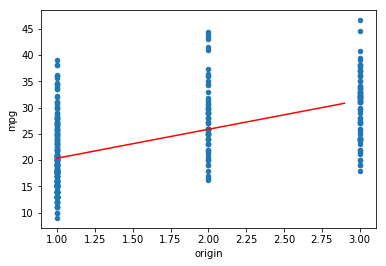

In [23]:
# we might treat categorical data as numerical but if would have diffrent meaning

# scatter-plot data
ax = df.plot(x='origin', y='mpg', kind='scatter')

# plot regression line on the same axes
p = result.params
x = np.arange(1, 3, 0.1)
ax = ax.plot(x, p.Intercept + p.origin  * x, 'r' )



In [9]:
# indicate which columns should be treated as categorical
df_cat = df.astype({'origin': 'category'})
df_cat.dtypes

mpg              float64
cylinders          int64
displacement     float64
horsepower        object
weight             int64
acceleration     float64
year               int64
origin          category
name              object
dtype: object

In [36]:
# dmatrices encodes categorical data in 'one-hot' style
# diffrent type of encodings -> see e.g. http://pbpython.com/categorical-encoding.html
y, X = dmatrices('mpg ~ weight + origin  ', data=df_cat, return_type='dataframe') 
X.dtypes
X.head()

# you might also use function 'C()' for indicating categorical variabel
# y, X = dmatrices('mpg ~ C(cylinders) -1 ', data=df, return_type='dataframe') 

,Intercept,origin[T.2],origin[T.3],weight
0,1.0,0.0,0.0,3504.0
1,1.0,0.0,0.0,3693.0
2,1.0,0.0,0.0,3436.0
3,1.0,0.0,0.0,3433.0
4,1.0,0.0,0.0,3449.0


In [63]:
#We can also have other encoding
df_usa = pd.get_dummies(df, columns=["origin"])
df_usa.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,name,origin_1,origin_2,origin_3
0,18.0,8,307.0,130,3504,12.0,70,chevrolet chevelle malibu,1,0,0
1,15.0,8,350.0,165,3693,11.5,70,buick skylark 320,1,0,0
2,18.0,8,318.0,150,3436,11.0,70,plymouth satellite,1,0,0
3,16.0,8,304.0,150,3433,12.0,70,amc rebel sst,1,0,0
4,17.0,8,302.0,140,3449,10.5,70,ford torino,1,0,0


In [66]:
#coding of categorical predictors has no influance on results
yy, XX = dmatrices('mpg ~ origin_1', data=df_usa, return_type='dataframe') 
model = sm.OLS(yy, XX) 
result = model.fit() 
p = result.params
p.Intercept, p.origin_1,p.Intercept + p.origin_1


(29.248322147651013, -9.176547954102615, 20.0717741935484)

In [ ]:
#change coding
df_usa["origin_1"].replace({0: -1},inplace=True)
df_usa["origin_1"]


In [68]:
#coding of categorical predictors has no influance on results
yy, XX = dmatrices('mpg ~ origin_1', data=df_usa, return_type='dataframe') 
model = sm.OLS(yy, XX) 
result = model.fit() 
p = result.params
p.Intercept, p.origin_1,p.Intercept + p.origin_1

(24.66004817059969, -4.588273977051303, 20.071774193548386)

In [ ]:
#go to the orginal one-hot coding
df_usa["origin_1"].replace({-1: 0},inplace=True)
df_usa["origin_1"]

# 2. Categorical response - classification setting #

In [41]:
# Let us try to predict if a car is from USA (origin = 1)
# Preper the data
y, X = dmatrices('origin_1 ~ weight + displacement - 1 ', df_usa, return_type = 'dataframe')

# Use statsmodels logistic regression
logit = sm.Logit(y, X)
result = logit.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.294936
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.554     
Dependent Variable: origin_1         AIC:              238.1792  
Date:               2020-11-04 13:17 BIC:              246.1471  
No. Observations:   397              Log-Likelihood:   -117.09   
Df Model:           1                LL-Null:          -262.70   
Df Residuals:       395              LLR p-value:      2.6832e-65
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
weight        -0.0049    0.0006  -7.6923  0.0000  -0.0062  -0.0037
displacement   0.0955    0.0128   7.4538  0.0000   0.0704   0.1207
=================================================================

"""

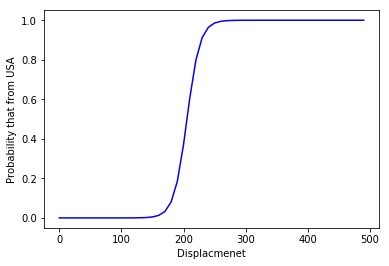

In [23]:
# Let us plot fitted line

def predict_prob_USA(model, displacement):
    return model.predict([weight, displacement])

# X.describe()

weight = 4000              # that is ~ 1800 kg
dis = np.arange(0,500,10)  # 200 cubic inches ~ 3,2 l
prob_usa = np.array( [predict_prob_USA(result,weight,di) for di in dis])
_ = plt.plot(dis, prob_usa, 'b' )
_ = plt.ylabel("Probability that from USA")
_ = plt.xlabel("Displacmenet")


Optimization terminated successfully.
         Current function value: 0.549956
         Iterations 9


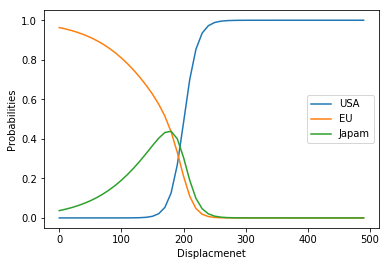

In [44]:
# Let us plot logistict regression line for each case (USA, EU, Japan)

# First we build the model with MNLogit function from statmodels package
y, X = dmatrices('origin ~ weight + displacement - 1 ', df, return_type = 'dataframe')
model=sm.MNLogit(y,X)
result = model.fit()
#result.summary2()

# Then we plot using result.predict() function
weight = 4000              # that is ~ 1800 kg
dis = np.arange(0,500,10)  # 200 cubic inch ~ 3,2 l
prob = np.array( [result.predict([weight, di]) for di in dis])
ax = plt.plot(dis, prob.reshape(50,3))
_ = plt.ylabel("Probabilities")
_ = plt.xlabel("Displacmenet")
_ = plt.legend(iter(ax), ('USA', 'EU', 'Japam'))



In [79]:
#fit coef. by maximazing log-likelihood
?sm.MNLogit.fit()

In [48]:
# To test the model we will use sklearn package - 
# in practice it has more convinient methods (e.g. for metrics)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

# Split the data into training (80%) and validation set (20%)
mask = np.random.rand(len(df)) < 0.8
train = df[mask]
valid = df[~mask]
        
# Prepare the data 
model_formula = 'origin ~ weight + displacement + cylinders '
y_train, X_train = dmatrices(model_formula, data=train, return_type='dataframe')   
y_valid, X_valid = dmatrices(model_formula, data=valid, return_type='dataframe')

# sklearn output, set  C = 1e9 to avoid regularization
model = LogisticRegression(fit_intercept = False, C = 1e9)
y_train = np.array(y_train).reshape(len(y_train,))
result = model.fit(X_train, y_train)

# accuracy of our prediction on validation set
print("Training accuracy: ", accuracy_score(y_train, model.predict(X_train)))

# Log_loss on validation set -> we use  model.predict_proba() 
print("Training log-loss", log_loss(y_train, model.predict_proba(X_train)))

# accuracy of our prediction on validation set
print("Validation accuracy: ", accuracy_score(y_valid, model.predict(X_valid)))

# accuracy of our prediction on validation set
print("Confusion_matrix: \n", confusion_matrix(y_valid, model.predict(X_valid)))

Training accuracy:  0.7286585365853658
Training log-loss 0.5441817164933143
Validation accuracy:  0.7681159420289855
Confusion_matrix: 
 [[39  2  3]
 [ 1  6  5]
 [ 3  2  8]]


In [50]:
#logistic loss = cross-entropy = - log-likelihood
?log_loss

## Decision Boundries for  linearly separable data ##

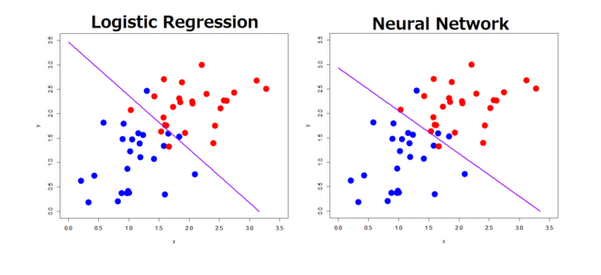

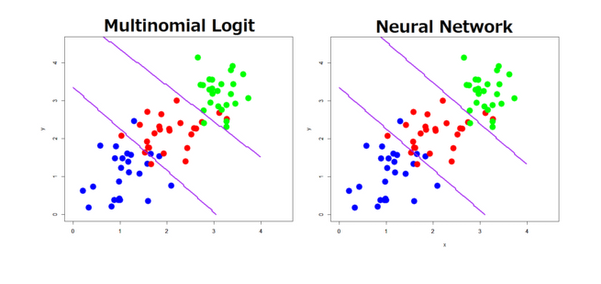

In [18]:
show_image('http://ki.pwr.edu.pl/lemiesz/info/1.png', size = (10,10))
show_image('http://ki.pwr.edu.pl/lemiesz/info/2.png', size = (10,10))



## Decision Boundries for  data that are note linearly separable ##


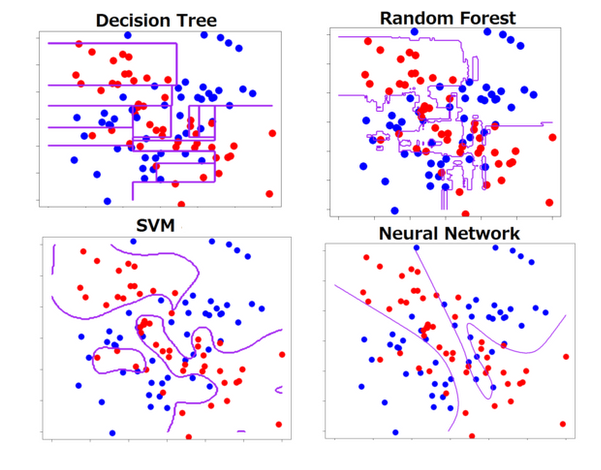

In [16]:
show_image('http://ki.pwr.edu.pl/lemiesz/info/3.png', size = (10,10))

# 3. Decision Tree Classifier #

In [31]:
from sklearn import tree

model = tree.DecisionTreeClassifier(criterion="entropy")
result = model.fit(X_train, y_train)

# accuracy of our prediction on validation set
print("Training accuracy: ", accuracy_score(y_true=y_train, y_pred=model.predict(X_train)))

# Log_loss on validation set -> we use  model.predict_proba() 
print("Training log-loss", log_loss(y_train, model.predict_proba(X_train)))

# accuracy of our prediction on validation set
print("Validation accuracy: ", accuracy_score(y_true=y_valid, y_pred=model.predict(X_valid)))

# accuracy of our prediction on validation set
print("Confusion_matrix: \n", confusion_matrix(y_true=y_valid, y_pred=model.predict(X_valid)))

Training accuracy:  0.9937694704049844
Training log-loss 0.01026740456699377
Validation accuracy:  0.868421052631579
Confusion_matrix: 
 [[49  2  1]
 [ 2  8  3]
 [ 0  2  9]]


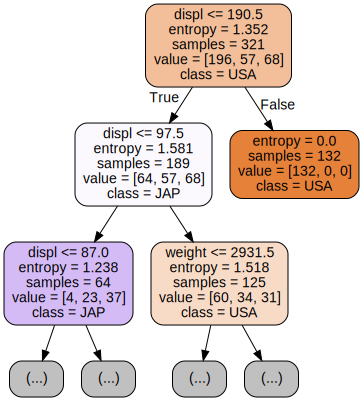

In [32]:
# We can see the tre, but You need to install graphviz 
# see e.g. https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft

import graphviz 
dot_data = tree.export_graphviz(result, out_file=None, filled=True, rounded=True, max_depth=2, class_names=['USA','EU','JAP'], feature_names=['int','weight','displ', 'cylin'])
graph = graphviz.Source(dot_data) 
graph